## Design av ett enkelt servo

!["text"](servo.png)

Blockschemat ovan visar ett positionsservo, där regulatorn $F(s)$ återkopplar positionsfelet (reglerfelet) $e$ och påverkar processen $G(s)$, som beskrivs av överföringsfunktionen

$$
  G(s) = \frac{3}{s(1+0.015s+0.0001s^2)} = \frac{3\cdot 10^4}{s(s^2+150s+10^4)}
$$

Uppgiften är att finna en regulator $F(s)$, som uppfyller följande specifikationer:

> 1. Börvärdesföljning: rampfel $\le$ 0.5 mm då referensen $r$ är en ramp 30 mm/s
> 2. Laststörning: positionsfel $\le$ 0.5 mm vid stegstörning $v=15$
> 3. Stabilitet: fasmarginal $\varphi_m \ge 45^\circ$
> 4. Snabbhet: $\omega_c =70$ rad/s 

### Steg 1: Försök med P-reglering

Vad kan åstadkommas med en P-regulator $u(t)=K_p e(t)$? 

> Krav 1: Reglerfelet vid en börvärdesramp $r=30$ mm/s kan beräknas med slutvärdessatsen:
>  $$
>      \lim_{t\rightarrow\infty} e_r(t) = \lim_{s\rightarrow 0} s\cdot\frac{1}{1+F(s)G(s)}\cdot\frac{30}{s^2} = \frac{10}{K_p}
>  $$
> dvs kravet är uppfyllt om $K_p \ge 20$.

> Krav 2: Positionsfelet vid en stegstörning $v=15$ beräknas på liknande sätt:
> $$
>   \lim_{t\rightarrow\infty} y_v(t) = \lim_{s\rightarrow 0} s\cdot\frac{G(s)}{1+F(s)G(s)}\cdot\frac{15}{s} = \frac{15}{K_p}
> $$  
> dvs kravet är uppfyllt om $K_p \ge 30$.

Slutsatsen så långt är alltså att en P-regulator med förstärkningen $K_p = 30$ tillfredsställer de två första kraven. Låt oss undersöka vilka egenskaper det återkopplade systemet får med denna regulator!

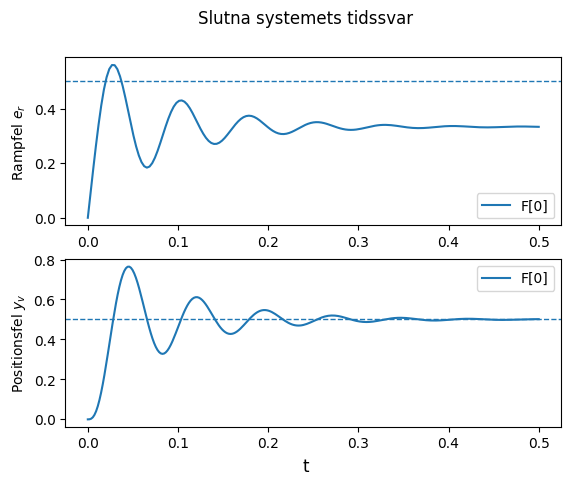

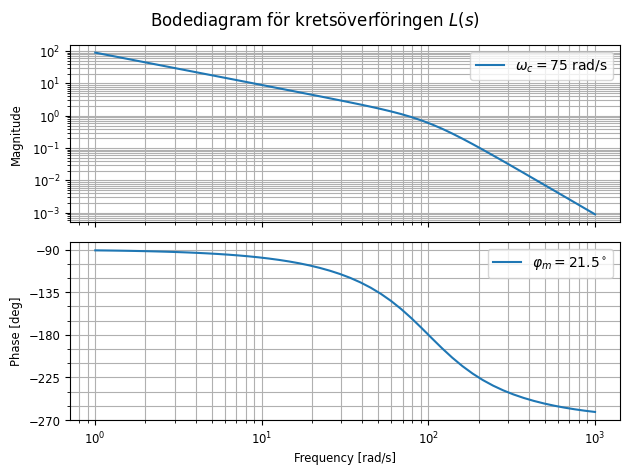

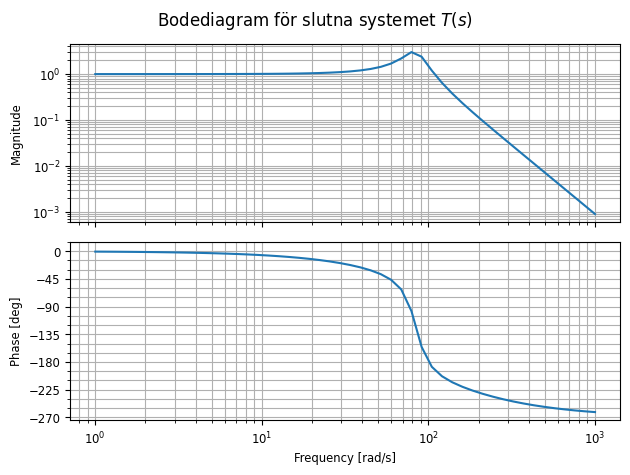

In [13]:
import numpy as np
import control as ct
import matplotlib as mpl
import matplotlib.pyplot as plt

s = ct.tf('s')
G = 3*10**4/(s*(s**2+150*s+10**4))

def tidssvar(F):
    L = [Fi*G for Fi in F]
    fig, ax = plt.subplots(2, 1)
    for i in range(len(F)):
        t, er = ct.step_response(30/(s*(1+L[i])), 0.5)  # beräkna rampsvaret enligt krav 1
        ax[0].plot(t, er)
        t, yv = ct.step_response(15*G/(1+L[i]), 0.5)  # beräkna stegsvaret enligt krav 2
        ax[1].plot(t, yv)
        
    fig.suptitle('Slutna systemets tidssvar')
    fig.supxlabel('t')
    plt.subplot(2, 1, 1)
    plt.ylabel('Rampfel $e_r$')
    plt.axhline(0.5, linestyle='--', linewidth=1)
    plt.legend([f'F[{i}]' for i in range(len(F))])
    plt.subplot(2, 1, 2)
    plt.ylabel('Positionsfel $y_v$')
    plt.axhline(0.5, linestyle='--', linewidth=1)
    plt.legend([f'F[{i}]' for i in range(len(F))])
    plt.show()

def Lbode(F):
    L = [Fi*G for Fi in F]
    fig = plt.figure()
    wc = np.zeros(len(F))
    pm = np.zeros(len(F))
    for i in range(len(F)):
        ct.bode_plot(L[i], omega=np.logspace(0, 3))  # plotta Bodediagram för L(s)..
        gmi, pmi, wcgi, wcpi = ct.margin(L[i])      # .. och beräkna fasmarginal och skärfrekvens (krav 3 och 4)
        wc[i] = wcpi
        pm[i] = pmi
    
    fig.suptitle('Bodediagram för kretsöverföringen $L(s)$')
    plt.subplot(2, 1, 1)
    plt.legend([r'$\omega_c=$'+ f'{wc[i]:.0f}' + ' rad/s' for i in range(len(F))])
    plt.subplot(2, 1, 2)
    plt.legend([r'$\varphi_m=$'+ f'{pm[i]:.1f}' + r'$^\circ$' for i in range(len(F))])
    plt.show()

def Tbode(F):
    T = [Fi*G/(1+Fi*G) for Fi in F]
    fig = plt.figure()
    for i in range(len(F)):
        ct.bode_plot(T[i], omega=np.logspace(0, 3))

    fig.suptitle('Bodediagram för slutna systemet $T(s)$')
    plt.show()

Kp1 = 30
F = [Kp1]
tidssvar(F)
Lbode(F)
Tbode(F)

#### Observationer

> 1. Simuleringarna bekräftar att P-regulatorn uppfyller krav 1 med råge.
> 2. Krav 2 är som väntat precis uppfyllt. 
> 3. Bodediagrammet för kretsöverföringen visar att fasmarginalen är otillräcklig ($21.5^\circ$) enligt krav 3. Detta resulterar i att det slutna systemet får dålig dämpning och transienterna blir oscillativa, liksom att det slutna systemet $T(s)$ får en tydlig resonanstopp.
> 4. Skärfrekvensen $\omega_c$, som är ett mått på slutna systemets snabbhet, är tillräcklig enligt krav 4.

### Steg 2: Inför ett lag-filter för att uppfylla krav 1-3

För att få tillräcklig fasmarginal, så måste vi sänka förstärkningen $K_p$ (vilket kommer att sänka skärfrekvensen). För att ändå uppfylla krav 1 och 2 kan vi istället selektivt höja förstärkningen för låga frekvenser med ett lagfilter. Krav 3 anger $\varphi_m\ge 45^\circ$, men eftersom ett lagfilter kommer att ge ytterligare negativ fasförskjutning, så siktar vi först på att ha en fasmarginal på $55^\circ$. Vi måste då sänka skärfrekvensen från c:a $75$ rad/s till c:a $40$ rad/s, vilket innebär $K_p=40/3$ (ses enkelt genom att approximera $G(s)$ för lägre frekvenser med en integrator).

Vi inför sedan ett lagfilter

\begin{equation*}
  F_{lag}(s) = a\frac{1+\tau s}{1+a\tau s}
\end{equation*}

För att återställa förstärkningen för låga frekvenser, så väljer vi $a=30/(40/3)=2.25$. Valet $\tau=3/\omega_c=3/40$ ger c:a $10^\circ$ fasförlust vid $\omega_c$, vilket vi har tagit höjd för vid valet av skärfrekvens ovan.

Flag =  <TransferFunction>: sys[588]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.1687 s + 2.25
---------------
 0.1687 s + 1



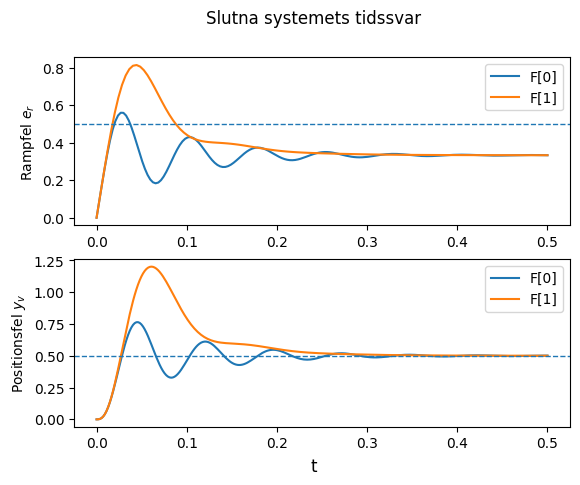

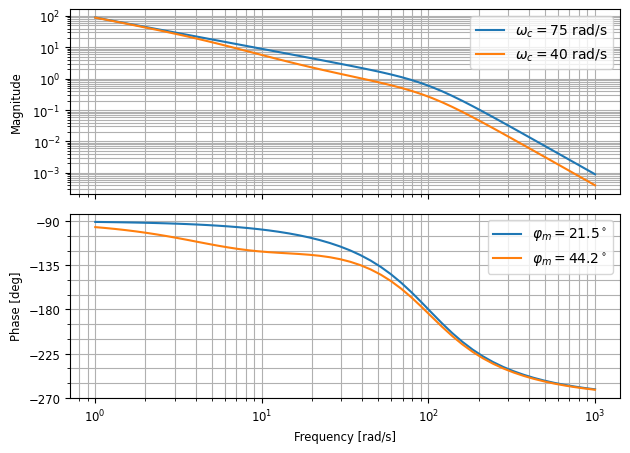

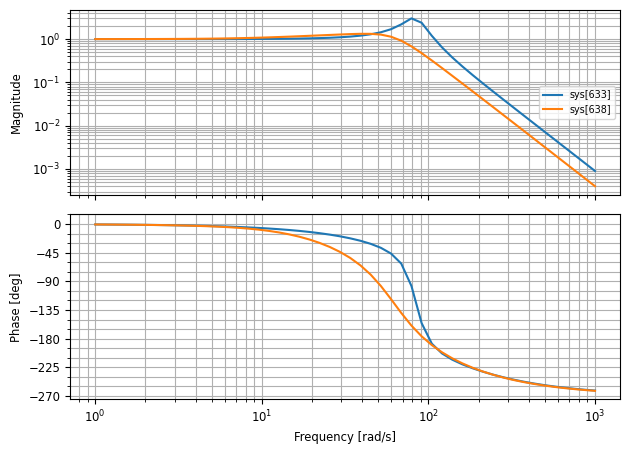

In [14]:
Kp2 = 40/3
a = Kp1/Kp2
tau = 3/40
Flag = a*(1+tau*s)/(1+a*tau*s)
F = [Kp1, Kp2*Flag]
print('Flag = ', Flag)
tidssvar(F)
Lbode(F)
Tbode(F)

#### Observationer

> 1. Krav 1 är uppfyllt på samma sätt som i steg 1.
> 2. Samma sak gäller krav 2. 
> 3. Krav 3 på fasmarginal är uppfyllt med en felmarginal på $1^\circ$.
> 4. Skärfrekvensen $\omega_c$ har sänkts i steg 2, vilket innebär att krav 4 inte längre är uppfyllt.

### Steg 3: Inför ett lead-filter för att uppfylla krav 4

Det återstår nu att öka skärfrekvensen till stipulerade $70$ rad/s, och vi passar också på att öka fasmarginalen till $60^\circ$ för att få ett ännu bättre dämpat system. Båda sakerna kan åstadkommas genom att höja fasen med ett lead-filter

\begin{equation*}
  F_{lead}(s) = \frac{1+\tau_d s}{1+(\tau_d/b) s}
\end{equation*}

Av Bode-diagrammet ovan framgår att vi måste höja fasen med c:a $40^\circ$ vid den nya skärfrekvensen. Valet $b=4.6$ ger önskat max faslyft, och med $\tau_d=\sqrt b/\omega_c=0.031$ hamnar det maximala faslyftet vid $\omega=\omega_c$. Med dessa val blir kretsöverföringens förstärkning vid skärfrekvensen något för hög:

\begin{equation*}
  |L(i\omega_c)| = K_p\cdot |F_{lag}(i\omega_c)|\cdot |F_{lead}(i\omega_c)| = 1.06,
\end{equation*}

så den färdiga regulatorn justeras därför till

\begin{equation*}
  F(s) = \frac{K_p}{1.06}F_{lag}(s)F_{lead}(s)
\end{equation*}





Flead =  <TransferFunction>: sys[651]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.03066 s + 1
--------------
0.006656 s + 1



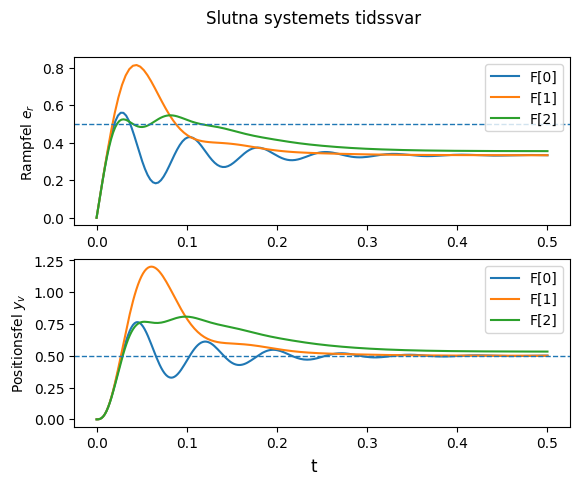

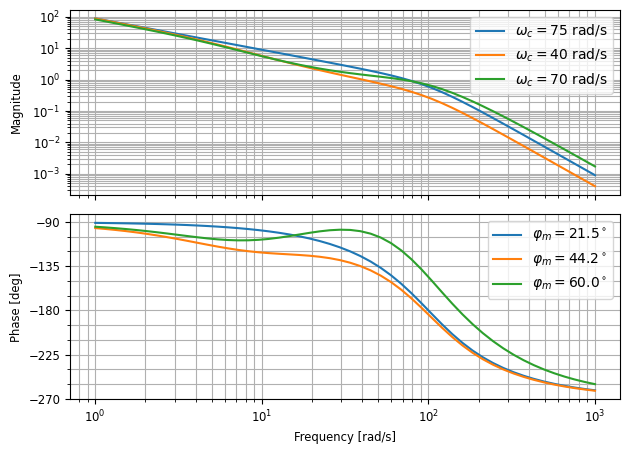

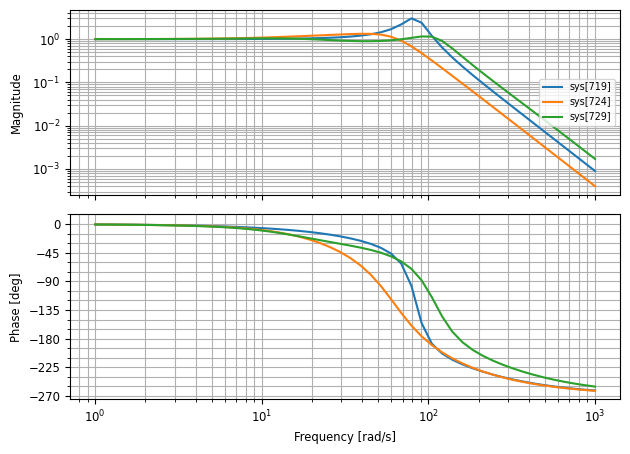

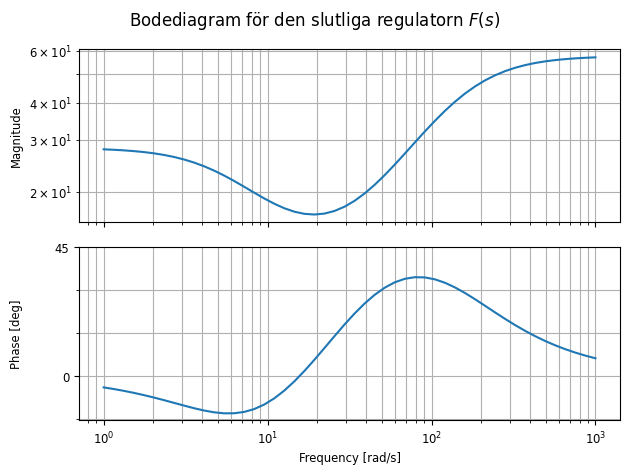

In [15]:
wc = 70 # önskad skärfrekvens
mag, phase, omega = ct.frequency_response(F[1]*G, wc)
phi = np.pi/3-(phase+np.pi)  # beräkna nödvändigt faslyft..
b = (1+np.sin(phi))/(1-np.sin(phi))  # .. vilket ger lämpligt b ≈ 4.6
taud = np.sqrt(b)/wc  # placera max faslyft vid den nya skärfrekvensen
Flead = (1+taud*s)/(1+taud/b*s)
mag, phase, omega = ct.frequency_response(F[1]*Flead*G, wc) # ≈ 1.066
Kp3 = Kp2/mag
F = [Kp1, Kp2*Flag, Kp3*Flag*Flead]
print('Flead = ', Flead)
tidssvar(F)
Lbode(F)
Tbode(F)

fig = plt.figure()
ct.bode_plot(F[2], omega=np.logspace(0, 3))
fig.suptitle('Bodediagram för den slutliga regulatorn $F(s)$')
plt.show()

Vi avslutar med att visa det slutna systemets stegsvar för ändringar i referensvärdet för de tre framtagna regulatorerna. 

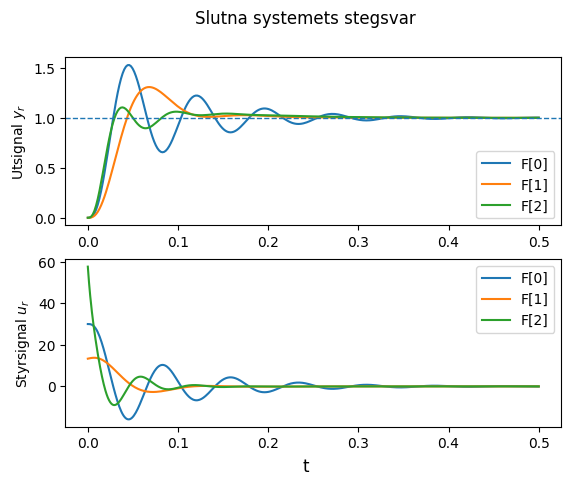

In [16]:
L = [Fi*G for Fi in F]
fig, ax = plt.subplots(2, 1)
for i in range(len(F)):
        t, yr = ct.step_response(L[i]/(1+L[i]), 0.5)  
        ax[0].plot(t, yr)
        t, ur = ct.step_response(F[i]/(1+L[i]), 0.5)  
        ax[1].plot(t, ur)

fig.suptitle('Slutna systemets stegsvar')
fig.supxlabel('t')
plt.subplot(2, 1, 1)
plt.ylabel('Utsignal $y_r$')
plt.axhline(1, linestyle='--', linewidth=1)
plt.legend([f'F[{i}]' for i in range(len(F))])
plt.subplot(2, 1, 2)
plt.ylabel('Styrsignal $u_r$')
plt.legend([f'F[{i}]' for i in range(len(F))])
plt.show()

In [17]:
print('Brytfrekvenser är:')
print([40/(2.25*3), 40/3, 1/0.03, 4.6/0.03])

Brytfrekvenser är:
[5.925925925925926, 13.333333333333334, 33.333333333333336, 153.33333333333331]


### Steg 4: Diskretisering av regulatorn

Den färdiga regulatorn skall nu förberedas för *samplad reglering*, där regulatorn kommer att representeras av ett stycke programkod. Vi börjar med att undersöka hur valet av diskretiseringsmetod påverkar regulatorns frekvenskurva. Vi väljer här preliminärt ett samplingsintervall $h=0.01$ s. 

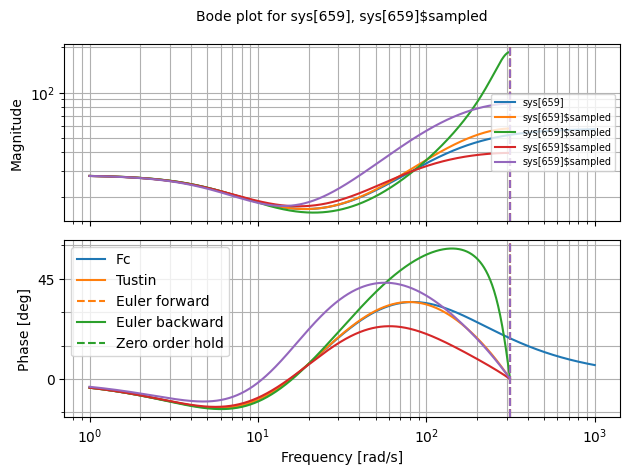

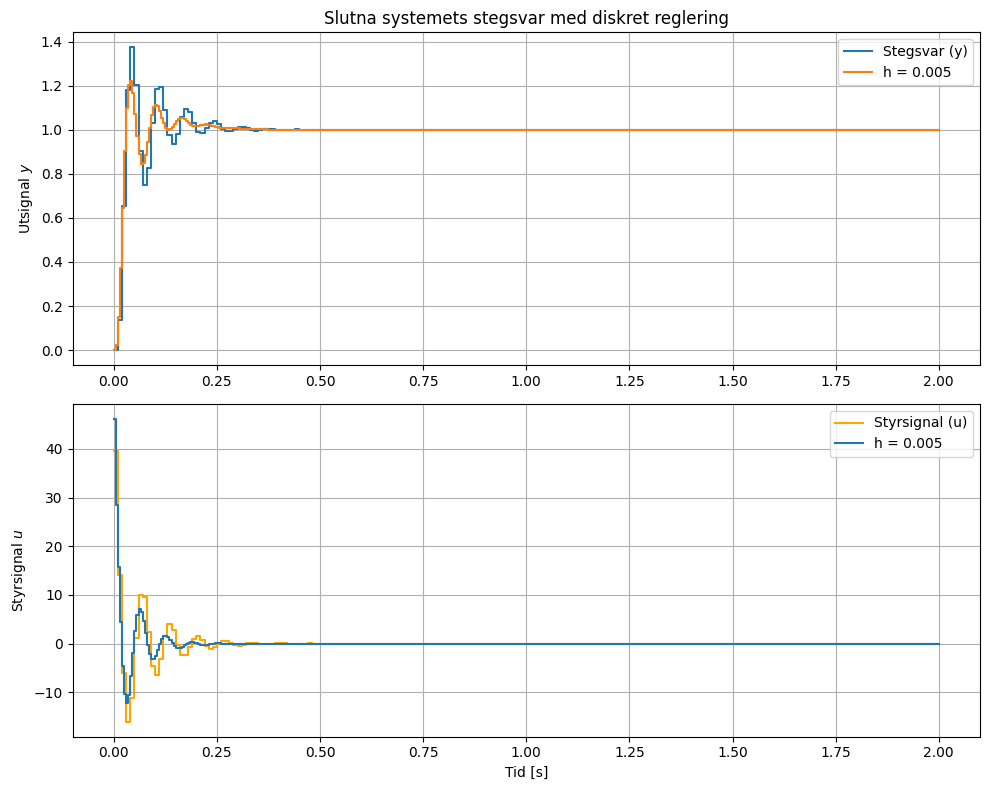

In [ ]:

Fc = F[2]
h = 0.01    # samplingsintervall
Fd_tustin = ct.sample_system(Fc, h, 'bilinear')
Fd_forward = ct.sample_system(Fc, h, 'euler')
Fd_backward = ct.sample_system(Fc, h, 'backward_diff')
Fd_zoh = ct.sample_system(Fc, h, 'zoh')

Gd_zoh = ct.sample_system(G, h, method='zoh')

# Skapa det slutna diskreta systemet
L_d = Fd_tustin * Gd_zoh  # Öppen loop
T_d = L_d / (1 + L_d)     # Sluten loop

# Simulera stegsvar för börvärdesändringar
t, y = ct.step_response(T_d, T=2)                    # 2 sekunders simulering
t, u = ct.step_response(Fd_tustin / (1 + L_d), T=2)  # Styrsignalen


fig, axis = plt.subplots(2, 1)
ct.bode_plot([Fc, Fd_tustin, Fd_forward, Fd_backward, Fd_zoh], initial_phase=0)
plt.subplot(2, 1, 2)
plt.legend(['Fc', 'Tustin', 'Euler forward', 'Euler backward', 'Zero order hold'])

plt.show()

# Simulera stegsvar för börvärdesändringar
t, y = ct.step_response(T_d, T=2)  # 2 sekunders simulering
t, u = ct.step_response(Fd_tustin / (1 + L_d), T=2)  # Styrsignalen

# För h = 0.005
new_Fd_tustin = ct.sample_system(Fc, h/2, 'bilinear')
new_Gd_zoh = ct.sample_system(G, h/2, method='zoh')

new_L_d = new_Fd_tustin * new_Gd_zoh  # Öppen loop
new_T_d = new_L_d / (1 + new_L_d)     # Sluten loop

# Simulera stegsvar för börvärdesändringar
a, b = ct.step_response(new_T_d, T=2)                    # 2 sekunders simulering
a, c = ct.step_response(new_Fd_tustin / (1 + new_L_d), T=2)  # Styrsignalen

# Plotta resultatet
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Slutna systemets utsignal (stegsvar)
ax[0].step(t, y, where='post', label='Stegsvar (y)')
ax[0].set_ylabel('Utsignal $y$')
ax[0].step(a, b, where='post', label='h = 0.005')
ax[0].set_title('Slutna systemets stegsvar med diskret reglering')
ax[0].grid()
ax[0].legend()

# Styrsignalen (u)
ax[1].step(t, u, where='post', label='Styrsignal (u)', color='orange')
ax[1].set_ylabel('Styrsignal $u$')
ax[1].step(a, c, where='post', label='h = 0.005')
ax[1].set_xlabel('Tid [s]')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

Vilken metod föredrar du?